""

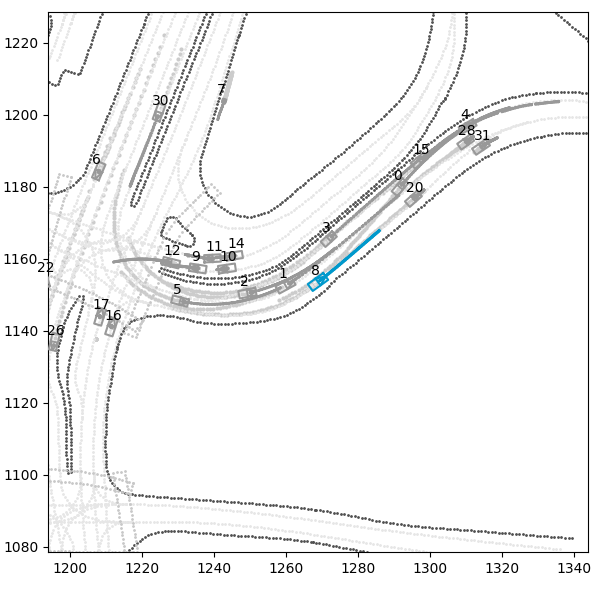

  4%|▍         | 44/1000 [00:40<14:32,  1.10it/s]


KeyboardInterrupt: 

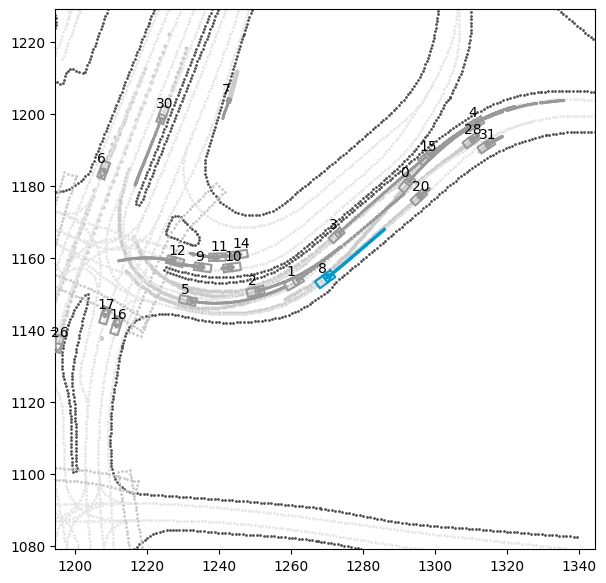

In [ ]:
import dataclasses
from typing import Any, Iterator, List, Tuple, Union, override

import flax.linen as nn
import gymnasium
import jax
import jax.numpy as jnp
import mediapy
import numpy as np
import skrl.envs.wrappers.jax as skrl_wrappers
from dm_env import specs
from IPython.display import clear_output, display
from jax import jit
from skrl import config
from skrl.agents.jax.ppo import PPO, PPO_DEFAULT_CONFIG
from skrl.memories.jax import RandomMemory
from skrl.models.jax import DeterministicMixin, GaussianMixin, Model
from skrl.trainers.jax import SequentialTrainer
from waymax import agents
from waymax import config as _config
from waymax import dataloader, datatypes, dynamics
from waymax import env as _env
from waymax import visualization

# Set the backend to "jax" or "numpy"
config.jax.backend = "jax"
config.jax.device = jax.devices("cpu")[0]


def setup_waymax():
    # path = "gs://waymo_open_dataset_motion_v_1_3_0/uncompressed/tf_example/training/training_tfexample.tfrecord@1000"
    path = "./data/training_tfexample.tfrecord@5"
    max_num_objects = 32
    data_loader_config = dataclasses.replace(
        _config.WOD_1_1_0_TRAINING,
        path=path,
        max_num_objects=max_num_objects,
        max_num_rg_points=30000,
    )
    data_iter = dataloader.simulator_state_generator(config=data_loader_config)
    sim_agent_config = _config.SimAgentConfig(
        agent_type=_config.SimAgentType.IDM,
        controlled_objects=_config.ObjectType.NON_SDC,
    )
    env_config = dataclasses.replace(
        _config.EnvironmentConfig(),
        max_num_objects=max_num_objects,
        sim_agents=[sim_agent_config],
    )
    dynamics_model = dynamics.InvertibleBicycleModel(normalize_actions=True)
    env = _env.PlanningAgentEnvironment(
        dynamics_model=dynamics_model,
        config=env_config,
        sim_agent_actors=[agents.create_sim_agents_from_config(sim_agent_config)],
        sim_agent_params=[{}],
    )
    return env, data_iter


class WaymaxWrapper(skrl_wrappers.Wrapper):
    def __init__(
        self,
        env: _env.PlanningAgentEnvironment,
        scenario_loader: Iterator[datatypes.SimulatorState],
    ):
        super().__init__(env)
        self._env: _env.PlanningAgentEnvironment
        self._scenario_loader = scenario_loader
        self._states: List[_env.PlanningAgentSimulatorState] = []  # For rendering

        self._jit_step = jit(self._env.step)
        self._jit_reset = jit(self._env.reset)
        self._jit_observe = jit(self._env.observe)
        self._jit_reward = jit(self._env.reward)
        self._jit_truncation = jit(self._env.truncation)
        self._jit_termination = jit(self._env.termination)

        print("action_spec", self.action_space)
        print("observation_spec", self.observation_space)

    @override
    def reset(self) -> Tuple[Union[np.ndarray, jax.Array], Any]:
        """Reset the environment

        :return: Observation, info
        :rtype: np.ndarray or jax.Array and any other info
        """
        self._state = self._jit_reset(next(self._scenario_loader))
        observation = self._jit_observe(self._state).reshape(1, 1)
        # observation = np.array(observation).reshape(1, 1)
        return observation, {}

    @override
    def step(self, actions: Union[np.ndarray, jax.Array]) -> Tuple[
        Union[np.ndarray, jax.Array],
        Union[np.ndarray, jax.Array],
        Union[np.ndarray, jax.Array],
        Union[np.ndarray, jax.Array],
        Any,
    ]:
        """Perform a step in the environment

        :param actions: The actions to perform
        :type actions: np.ndarray or jax.Array

        :return: Observation, reward, terminated, truncated, info
        :rtype: tuple of np.ndarray or jax.Array and any other info
        """
        actions = actions.flatten()
        action = datatypes.Action(data=actions, valid=jnp.ones((1,), dtype=bool))  # type: ignore
        self._state = self._jit_step(self._state, action)
        reward = self._jit_reward(self._state, action).reshape(1, 1)
        observation = self._jit_observe(self._state).reshape(1, 1)
        terminated = self._jit_termination(self._state).reshape(1, 1)
        truncated = self._jit_truncation(self._state).reshape(1, 1)

        # observation = np.array(observation).reshape(1, 1)
        # reward = np.array(reward).reshape(1, 1)
        # terminated = np.array(terminated).reshape(1, 1)
        # truncated = np.array(truncated).reshape(1, 1)
        return observation, reward, terminated, truncated, {}

    def state(self) -> Union[np.ndarray, jax.Array]:
        """Get the environment state

        :raises NotImplementedError: Not implemented

        :return: State
        :rtype: np.ndarray or jax.Array
        """
        raise NotImplementedError

    @override
    def render(self, *args, **kwargs) -> Any:
        """Render the environment

        :return: Any value from the wrapped environment
        :rtype: any
        """
        self._state: _env.PlanningAgentSimulatorState
        self._states.append(self._state)  # store state for video generation


    @override
    def close(self) -> None:
        """Close the environment"""
        print("Closing environment")
        imgs = []
        for state in self._states:
            imgs.append(visualization.plot_simulator_state(state, use_log_traj=False))
        mediapy.write_video("./waymax.mp4", imgs, fps=10)

    @property
    def observation_space(self) -> gymnasium.Space:
        """The observation specs of this environment, without batch dimension."""
        observation_spec: specs.BoundedArray = self._env.observation_spec()
        return gymnasium.spaces.Box(
            shape=observation_spec.shape,  # type: ignore
            low=observation_spec.minimum,
            high=observation_spec.maximum,
            dtype=observation_spec.dtype,  # type: ignore
        )

    @property
    def action_space(self) -> gymnasium.Space:
        """Action space"""
        action_spec: specs.BoundedArray = self._env.action_spec().data  # type: ignore
        return gymnasium.spaces.Box(
            low=action_spec.minimum, high=action_spec.maximum, dtype=action_spec.dtype  # type: ignore
        )


class Policy(GaussianMixin, Model):
    def __init__(
        self,
        observation_space,
        action_space,
        device=None,
        clip_actions=False,
        clip_log_std=True,
        min_log_std=-20,
        max_log_std=2,
        reduction="sum",
        **kwargs
    ):
        Model.__init__(self, observation_space, action_space, device, **kwargs)
        GaussianMixin.__init__(
            self, clip_actions, clip_log_std, min_log_std, max_log_std, reduction
        )

    @nn.compact  # marks the given module method allowing inlined submodules
    def __call__(self, inputs, role):
        x = nn.relu(nn.Dense(64)(inputs["states"]))
        x = nn.relu(nn.Dense(64)(x))
        x = nn.Dense(self.num_actions)(x)  # type: ignore
        log_std = self.param("log_std", lambda _: jnp.zeros(self.num_actions))
        # Pendulum-v1 action_space is -2 to 2
        return 2 * nn.tanh(x), log_std, {}


class Value(DeterministicMixin, Model):
    def __init__(
        self, observation_space, action_space, device=None, clip_actions=False, **kwargs
    ):
        Model.__init__(self, observation_space, action_space, device, **kwargs)
        DeterministicMixin.__init__(self, clip_actions)

    @nn.compact  # marks the given module method allowing inlined submodules
    def __call__(self, inputs, role):
        x = nn.relu(nn.Dense(64)(inputs["states"]))
        x = nn.relu(nn.Dense(64)(x))
        x = nn.Dense(1)(x)
        return x, {}


env, data_iter = setup_waymax()
env = WaymaxWrapper(env, data_iter)

# instantiate a memory as rollout buffer (any memory can be used for this)
memory = RandomMemory(memory_size=64, num_envs=env.num_envs)


# instantiate the agent's models (function approximators).
# PPO requires 2 models, visit its documentation for more details
# https://skrl.readthedocs.io/en/latest/api/agents/ppo.html#models
models = {}
models["policy"] = Policy(env.observation_space, env.action_space, clip_actions=True)
models["value"] = Value(env.observation_space, env.action_space)

# instantiate models' state dict
for role, model in models.items():
    model.init_state_dict(role)


# configure and instantiate the agent (visit its documentation to see all the options)
# https://skrl.readthedocs.io/en/latest/api/agents/ppo.html#configuration-and-hyperparameters
cfg = PPO_DEFAULT_CONFIG.copy()


agent = PPO(
    models=models,
    memory=memory,
    cfg=cfg,
    observation_space=env.observation_space,
    action_space=env.action_space,
)


# configure and instantiate the RL trainer
cfg_trainer = {"timesteps": 1000, "headless": True, "close_environment_at_exit": True}
trainer = SequentialTrainer(cfg=cfg_trainer, env=env, agents=[agent])

# start training
trainer.train()

# visualize the training
trainer.headless = False
trainer.eval()

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float32[32,91,5]
The error occurred while tracing the function plot_simulator_state at c:\Users\Haako\Documents\WaymaxAutoPlanner\.venv\Lib\site-packages\waymax\visualization\viz.py:245 for jit. This concrete value was not available in Python because it depends on the values of the arguments state.log_trajectory.length, state.log_trajectory.width, state.log_trajectory.x, state.log_trajectory.y, and state.log_trajectory.yaw.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

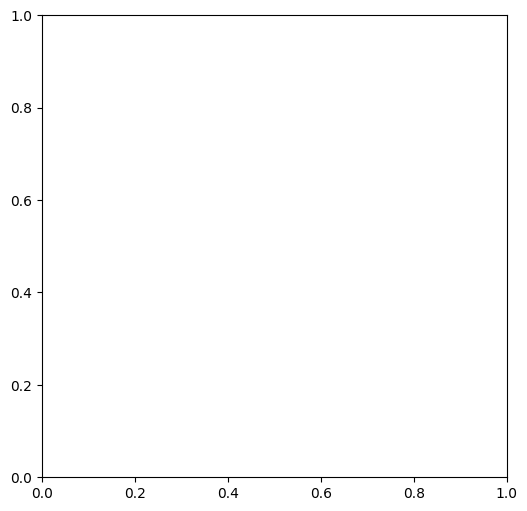

In [ ]:
import numpy as np
import mediapy
from tqdm import tqdm
import dataclasses

from waymax import config as _config
from waymax import dataloader
from waymax import datatypes
from waymax import visualization

max_num_objects = 32
config = dataclasses.replace(
    _config.WOD_1_1_0_TRAINING,
    max_num_objects=max_num_objects,
    max_num_rg_points=30000,
    path="./data/training_tfexample.tfrecord@5",
)
data_iter = dataloader.simulator_state_generator(config=config)
scenario = next(data_iter)


img = visualization.plot_simulator_state(scenario, use_log_traj=True)
imgs = [img]
state = scenario
for _ in range(scenario.remaining_timesteps):
  state = datatypes.update_state_by_log(state, num_steps=1)
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=True))


mediapy.show_video(imgs, fps=10)